In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Carregando o dataset
df = pd.read_csv('./dataset/train.csv')
df.head()

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


In [3]:
# Análise descritiva do dataset
df.describe()

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,White Blood cell count (thousand per microliter),Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5
count,20656.000000,22083.000000,16047.000000,16097.000000,19956.0,19931.0,19936.0,19943.0,19913.0,19921.000000,19935.000000,19928.000000,19861.000000,19982.000000,19970.000000,19930.000000
mean,6.974148,4.898871,34.526454,41.972852,0.0,0.0,0.0,1.0,0.0,2.003062,7.486224,0.592483,0.551886,0.536233,0.497747,0.461917
std,4.319475,0.199663,9.852598,13.035501,0.0,0.0,0.0,0.0,0.0,1.411919,2.653393,0.491385,0.497313,0.498698,0.500007,0.498560
min,0.000000,4.092727,18.000000,20.000000,0.0,0.0,0.0,1.0,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.763109,26.000000,31.000000,0.0,0.0,0.0,1.0,0.0,1.000000,5.424703,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,4.899399,35.000000,42.000000,0.0,0.0,0.0,1.0,0.0,2.000000,7.477132,1.000000,1.000000,1.000000,0.000000,0.000000
75%,11.000000,5.033830,43.000000,53.000000,0.0,0.0,0.0,1.0,0.0,3.000000,9.526152,1.000000,1.000000,1.000000,1.000000,1.000000
max,14.000000,5.609829,51.000000,64.000000,0.0,0.0,0.0,1.0,0.0,4.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Removendo colunas que não nos interessam nas análises já que não são relevantes para a classificação ou pelo fato de estarem mascaradas como Test e Symptom
df.drop(["Patient Id", "Patient First Name", "Family Name", "Father's name", "Institute Name",
        "Location of Institute", "Test 1", "Test 2", "Test 3", "Test 4", "Test 5", "Parental consent",
        "Place of birth", "Symptom 1", "Symptom 2", "Symptom 3", "Symptom 4", "Symptom 5", "Patient Age",
        "Status", "Birth asphyxia", "Autopsy shows birth defect (if applicable)", "Follow-up"],
        axis=1, inplace=True)

df = df.rename(columns= {
        "Father's age": "fathers_age",
        "Mother's age": "mothers_age",
        'Genes in mother\'s side': 'mother_has_genetic_defect',
        'Inherited from father': 'father_has_genetic_defect',
        'Maternal gene': 'mothers_family_has_genetic_defect',
        'Paternal gene': 'fathers_family_has_genetic_defect',
        'Respiratory Rate (breaths/min)': 'respiratory_rate',
        'Heart Rate (rates/min': 'heart_rate',
        'Gender': 'gender',
        'Folic acid details (peri-conceptional)': 'folic_acid_details',
        'H/O serious maternal illness': 'history_of_pregnancy_complications',
        'H/O radiation exposure (x-ray)': 'history_of_radiation_exposure',
        'H/O substance abuse': 'history_of_substance_abuse',
        'Assisted conception IVF/ART': 'assisted_conception',
        'History of anomalies in previous pregnancies': 'history_of_previous_pregnancy_anomaly',
        'No. of previous abortion': 'num_of_previous_abortion',
        'Birth defects': 'birth_defects',
        'Blood test result': 'blood_test_result',
        'Blood cell count (mcL)': 'blood_cell_count', 
        'White Blood cell count (thousand per microliter)': 'white_blood_cell_count',
        'Genetic Disorder': 'genetic_disorder',
        'Disorder Subclass': 'disorder_subclass'
})

df.head()

,mother_has_genetic_defect,father_has_genetic_defect,mothers_family_has_genetic_defect,fathers_family_has_genetic_defect,blood_cell_count,mothers_age,fathers_age,respiratory_rate,heart_rate,gender,...,history_of_radiation_exposure,history_of_substance_abuse,assisted_conception,history_of_previous_pregnancy_anomaly,num_of_previous_abortion,birth_defects,white_blood_cell_count,blood_test_result,genetic_disorder,disorder_subclass
0,Yes,No,Yes,No,4.760603,NaN,NaN,Normal (30-60),Normal,NaN,...,No,No,No,Yes,NaN,NaN,9.857562,NaN,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,Yes,Yes,No,No,4.910669,NaN,23.0,Tachypnea,Normal,NaN,...,Not applicable,Not applicable,No,Yes,NaN,Multiple,5.522560,normal,NaN,Cystic fibrosis
2,Yes,No,No,No,4.893297,41.0,22.0,Normal (30-60),Tachycardia,NaN,...,Yes,NaN,Yes,Yes,4.0,Singular,NaN,normal,Multifactorial genetic inheritance disorders,Diabetes
3,Yes,No,Yes,No,4.705280,21.0,NaN,Tachypnea,Normal,Male,...,-,Not applicable,NaN,Yes,1.0,Singular,7.919321,inconclusive,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,Yes,No,NaN,Yes,4.720703,32.0,NaN,Tachypnea,Tachycardia,Male,...,-,Not applicable,Yes,No,4.0,Multiple,4.098210,NaN,Multifactorial genetic inheritance disorders,Cancer


Vamos remover os espaços em branco nos dados também para podermos plotar a árvore de decisão com o graphviz no final, mas para isso precisamos antes tratar os dados faltantes.

O próximo passo é verificar os data types dos dados e verificar também se os uniques deles são o que esperamos.

In [5]:
# Verificando o tipo de dados de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   mother_has_genetic_defect              22083 non-null  object 
 1   father_has_genetic_defect              21777 non-null  object 
 2   mothers_family_has_genetic_defect      19273 non-null  object 
 3   fathers_family_has_genetic_defect      22083 non-null  object 
 4   blood_cell_count                       22083 non-null  float64
 5   mothers_age                            16047 non-null  float64
 6   fathers_age                            16097 non-null  float64
 7   respiratory_rate                       19934 non-null  object 
 8   heart_rate                             19970 non-null  object 
 9   gender                                 19910 non-null  object 
 10  folic_acid_details                     19966 non-null  object 
 11  hi

É normal ter várias colunas como `object` pois se repararmos no `head()` temos varios dados com `Yes` e `No` por exemplo.

Porém, ainda temos que verificar os uniques deles para vermos se é o que esperamos.

In [6]:
# Verificando os valores unicos de cada coluna
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

mother_has_genetic_defect: ['Yes' 'No']
father_has_genetic_defect: ['No' 'Yes' nan]
mothers_family_has_genetic_defect: ['Yes' 'No' nan]
fathers_family_has_genetic_defect: ['No' 'Yes']
blood_cell_count: [4.76060309 4.91066906 4.89329743 ... 5.1864702  4.85854267 4.73806671]
mothers_age: [nan 41. 21. 32. 40. 45. 44. 50. 28. 30. 24. 36. 51. 23. 49. 46. 18. 38.
 37. 42. 48. 25. 19. 47. 34. 35. 22. 33. 20. 26. 31. 29. 27. 43. 39.]
fathers_age: [nan 23. 22. 63. 44. 42. 56. 20. 24. 57. 48. 30. 55. 62. 43. 32. 41. 52.
 28. 31. 61. 35. 49. 50. 29. 64. 39. 34. 51. 25. 60. 53. 58. 26. 27. 59.
 47. 38. 54. 21. 37. 36. 33. 46. 40. 45.]
respiratory_rate: ['Normal (30-60)' 'Tachypnea' nan]
heart_rate: ['Normal' 'Tachycardia' nan]
gender: [nan 'Male' 'Female' 'Ambiguous']
folic_acid_details: ['No' 'Yes' nan]
history_of_pregnancy_complications: [nan 'Yes' 'No']
history_of_radiation_exposure: ['No' 'Not applicable' 'Yes' '-' nan]
history_of_substance_abuse: ['No' 'Not applicable' nan '-' 'Yes']
assisted

Podemos ver que precisamos fazer alguns tratamentos para `nan`, `Not available`, `Not applicable` e `-` por exemplo

Vamos primeiro verificar a quantidade de nan por coluna e depois converter os outros valores diferentes de nan, que também representam nan, para nan


In [7]:
# Verificar valores nulos
df.isna().sum()

mother_has_genetic_defect                   0
father_has_genetic_defect                 306
mothers_family_has_genetic_defect        2810
fathers_family_has_genetic_defect           0
blood_cell_count                            0
mothers_age                              6036
fathers_age                              5986
respiratory_rate                         2149
heart_rate                               2113
gender                                   2173
folic_acid_details                       2117
history_of_pregnancy_complications       2152
history_of_radiation_exposure            2153
history_of_substance_abuse               2195
assisted_conception                      2122
history_of_previous_pregnancy_anomaly    2172
num_of_previous_abortion                 2162
birth_defects                            2154
white_blood_cell_count                   2148
blood_test_result                        2145
genetic_disorder                         2146
disorder_subclass                 

In [8]:
# Trocando valores similares a nan para nan
df = df.replace('No record', np.nan)
df = df.replace('Not available', np.nan)
df = df.replace('Not applicable', np.nan)
df = df.replace('-', np.nan)

# Verificar unique values
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

# Verificar soma de valores nulos
df.isna().sum()

mother_has_genetic_defect: ['Yes' 'No']
father_has_genetic_defect: ['No' 'Yes' nan]
mothers_family_has_genetic_defect: ['Yes' 'No' nan]
fathers_family_has_genetic_defect: ['No' 'Yes']
blood_cell_count: [4.76060309 4.91066906 4.89329743 ... 5.1864702  4.85854267 4.73806671]
mothers_age: [nan 41. 21. 32. 40. 45. 44. 50. 28. 30. 24. 36. 51. 23. 49. 46. 18. 38.
 37. 42. 48. 25. 19. 47. 34. 35. 22. 33. 20. 26. 31. 29. 27. 43. 39.]
fathers_age: [nan 23. 22. 63. 44. 42. 56. 20. 24. 57. 48. 30. 55. 62. 43. 32. 41. 52.
 28. 31. 61. 35. 49. 50. 29. 64. 39. 34. 51. 25. 60. 53. 58. 26. 27. 59.
 47. 38. 54. 21. 37. 36. 33. 46. 40. 45.]
respiratory_rate: ['Normal (30-60)' 'Tachypnea' nan]
heart_rate: ['Normal' 'Tachycardia' nan]
gender: [nan 'Male' 'Female' 'Ambiguous']
folic_acid_details: ['No' 'Yes' nan]
history_of_pregnancy_complications: [nan 'Yes' 'No']
history_of_radiation_exposure: ['No' nan 'Yes']
history_of_substance_abuse: ['No' nan 'Yes']
assisted_conception: ['No' 'Yes' nan]
history_of_p

mother_has_genetic_defect                    0
father_has_genetic_defect                  306
mothers_family_has_genetic_defect         2810
fathers_family_has_genetic_defect            0
blood_cell_count                             0
mothers_age                               6036
fathers_age                               5986
respiratory_rate                          2149
heart_rate                                2113
gender                                    2173
folic_acid_details                        2117
history_of_pregnancy_complications        2152
history_of_radiation_exposure            12098
history_of_substance_abuse               12075
assisted_conception                       2122
history_of_previous_pregnancy_anomaly     2172
num_of_previous_abortion                  2162
birth_defects                             2154
white_blood_cell_count                    2148
blood_test_result                         2145
genetic_disorder                          2146
disorder_subc

Podemos perceber um aumento no total de NaN nas colunas e que nos uniques não aparecem mais os outros casos

Entretanto, apesar do XGBoost conseguir lidar com dados faltantes por default (seria apenas setar para 0 por exemplo), como são muitos, podemos ter um problema

Precisamos agora tratar esses NaN

Podemos tentar usar o fillna para preencher os valores nulos usando a moda da coluna em questão, mas pela quantidade de dado faltante acredito que vai enviesar

Ou podemos remover as linhas com valores nulos, acredito que o melhor seja seguir nessa linha pois como a quantidade de dados originais é grande, ainda teremos uma quantidade razoável

In [9]:
# Remover linhas com valores nulos
df = df.dropna()

# Reset index
df.reset_index(drop=True, inplace=True)

In [10]:
# Verificar soma de valores nulos
df.isna().sum()

mother_has_genetic_defect                0
father_has_genetic_defect                0
mothers_family_has_genetic_defect        0
fathers_family_has_genetic_defect        0
blood_cell_count                         0
mothers_age                              0
fathers_age                              0
respiratory_rate                         0
heart_rate                               0
gender                                   0
folic_acid_details                       0
history_of_pregnancy_complications       0
history_of_radiation_exposure            0
history_of_substance_abuse               0
assisted_conception                      0
history_of_previous_pregnancy_anomaly    0
num_of_previous_abortion                 0
birth_defects                            0
white_blood_cell_count                   0
blood_test_result                        0
genetic_disorder                         0
disorder_subclass                        0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   mother_has_genetic_defect              1828 non-null   object 
 1   father_has_genetic_defect              1828 non-null   object 
 2   mothers_family_has_genetic_defect      1828 non-null   object 
 3   fathers_family_has_genetic_defect      1828 non-null   object 
 4   blood_cell_count                       1828 non-null   float64
 5   mothers_age                            1828 non-null   float64
 6   fathers_age                            1828 non-null   float64
 7   respiratory_rate                       1828 non-null   object 
 8   heart_rate                             1828 non-null   object 
 9   gender                                 1828 non-null   object 
 10  folic_acid_details                     1828 non-null   object 
 11  hist

In [12]:
# Trocar os espaços por _ e colocar tudo em lowercase para podermos plotar a árvore de decisão mais tarde
df.replace(' ', '_', regex=True, inplace=True)

df.head()

,mother_has_genetic_defect,father_has_genetic_defect,mothers_family_has_genetic_defect,fathers_family_has_genetic_defect,blood_cell_count,mothers_age,fathers_age,respiratory_rate,heart_rate,gender,...,history_of_radiation_exposure,history_of_substance_abuse,assisted_conception,history_of_previous_pregnancy_anomaly,num_of_previous_abortion,birth_defects,white_blood_cell_count,blood_test_result,genetic_disorder,disorder_subclass
0,No,No,Yes,No,5.209058,45.0,44.0,Tachypnea,Tachycardia,Male,...,No,No,No,Yes,0.0,Multiple,6.669552,slightly_abnormal,Mitochondrial_genetic_inheritance_disorders,Leigh_syndrome
1,No,Yes,Yes,Yes,4.752272,44.0,42.0,Tachypnea,Tachycardia,Male,...,No,No,Yes,Yes,1.0,Multiple,6.397702,abnormal,Multifactorial_genetic_inheritance_disorders,Diabetes
2,Yes,Yes,Yes,No,4.751452,40.0,57.0,Normal_(30-60),Tachycardia,Ambiguous,...,Yes,No,Yes,Yes,3.0,Singular,9.382407,abnormal,Mitochondrial_genetic_inheritance_disorders,Mitochondrial_myopathy
3,No,Yes,Yes,Yes,4.876896,36.0,48.0,Tachypnea,Normal,Ambiguous,...,No,No,Yes,No,1.0,Singular,7.370477,normal,Single-gene_inheritance_diseases,Hemochromatosis
4,Yes,Yes,Yes,Yes,5.149614,23.0,49.0,Tachypnea,Normal,Female,...,Yes,Yes,No,Yes,0.0,Singular,9.855420,abnormal,Mitochondrial_genetic_inheritance_disorders,Leigh_syndrome


In [13]:
# Trocando o target de disorder_subclass para leigh_syndrome e alterando as linhas que não são leigh_syndrome para False e as que são para True
df['leigh_syndrome'] = df['disorder_subclass'].apply(lambda x: True if x == 'Leigh_syndrome' else False)
df.drop(['disorder_subclass', 'genetic_disorder'], axis=1, inplace=True)
df.head()

,mother_has_genetic_defect,father_has_genetic_defect,mothers_family_has_genetic_defect,fathers_family_has_genetic_defect,blood_cell_count,mothers_age,fathers_age,respiratory_rate,heart_rate,gender,...,history_of_pregnancy_complications,history_of_radiation_exposure,history_of_substance_abuse,assisted_conception,history_of_previous_pregnancy_anomaly,num_of_previous_abortion,birth_defects,white_blood_cell_count,blood_test_result,leigh_syndrome
0,No,No,Yes,No,5.209058,45.0,44.0,Tachypnea,Tachycardia,Male,...,Yes,No,No,No,Yes,0.0,Multiple,6.669552,slightly_abnormal,True
1,No,Yes,Yes,Yes,4.752272,44.0,42.0,Tachypnea,Tachycardia,Male,...,No,No,No,Yes,Yes,1.0,Multiple,6.397702,abnormal,False
2,Yes,Yes,Yes,No,4.751452,40.0,57.0,Normal_(30-60),Tachycardia,Ambiguous,...,No,Yes,No,Yes,Yes,3.0,Singular,9.382407,abnormal,False
3,No,Yes,Yes,Yes,4.876896,36.0,48.0,Tachypnea,Normal,Ambiguous,...,Yes,No,No,Yes,No,1.0,Singular,7.370477,normal,False
4,Yes,Yes,Yes,Yes,5.149614,23.0,49.0,Tachypnea,Normal,Female,...,No,Yes,Yes,No,Yes,0.0,Singular,9.855420,abnormal,True


In [14]:
# Verificar a quantidade de linhas que tem mother_has_genetic_defect = Yes e genetic_disorder = Mitochondrial_genetic_inheritance_disorders
df[(df['mother_has_genetic_defect'] == 'Yes') & (df['leigh_syndrome'] == True)].shape

(270, 21)

Loading...: 100%|██████████| 21/21 [00:00<00:00, 33.71it/s]


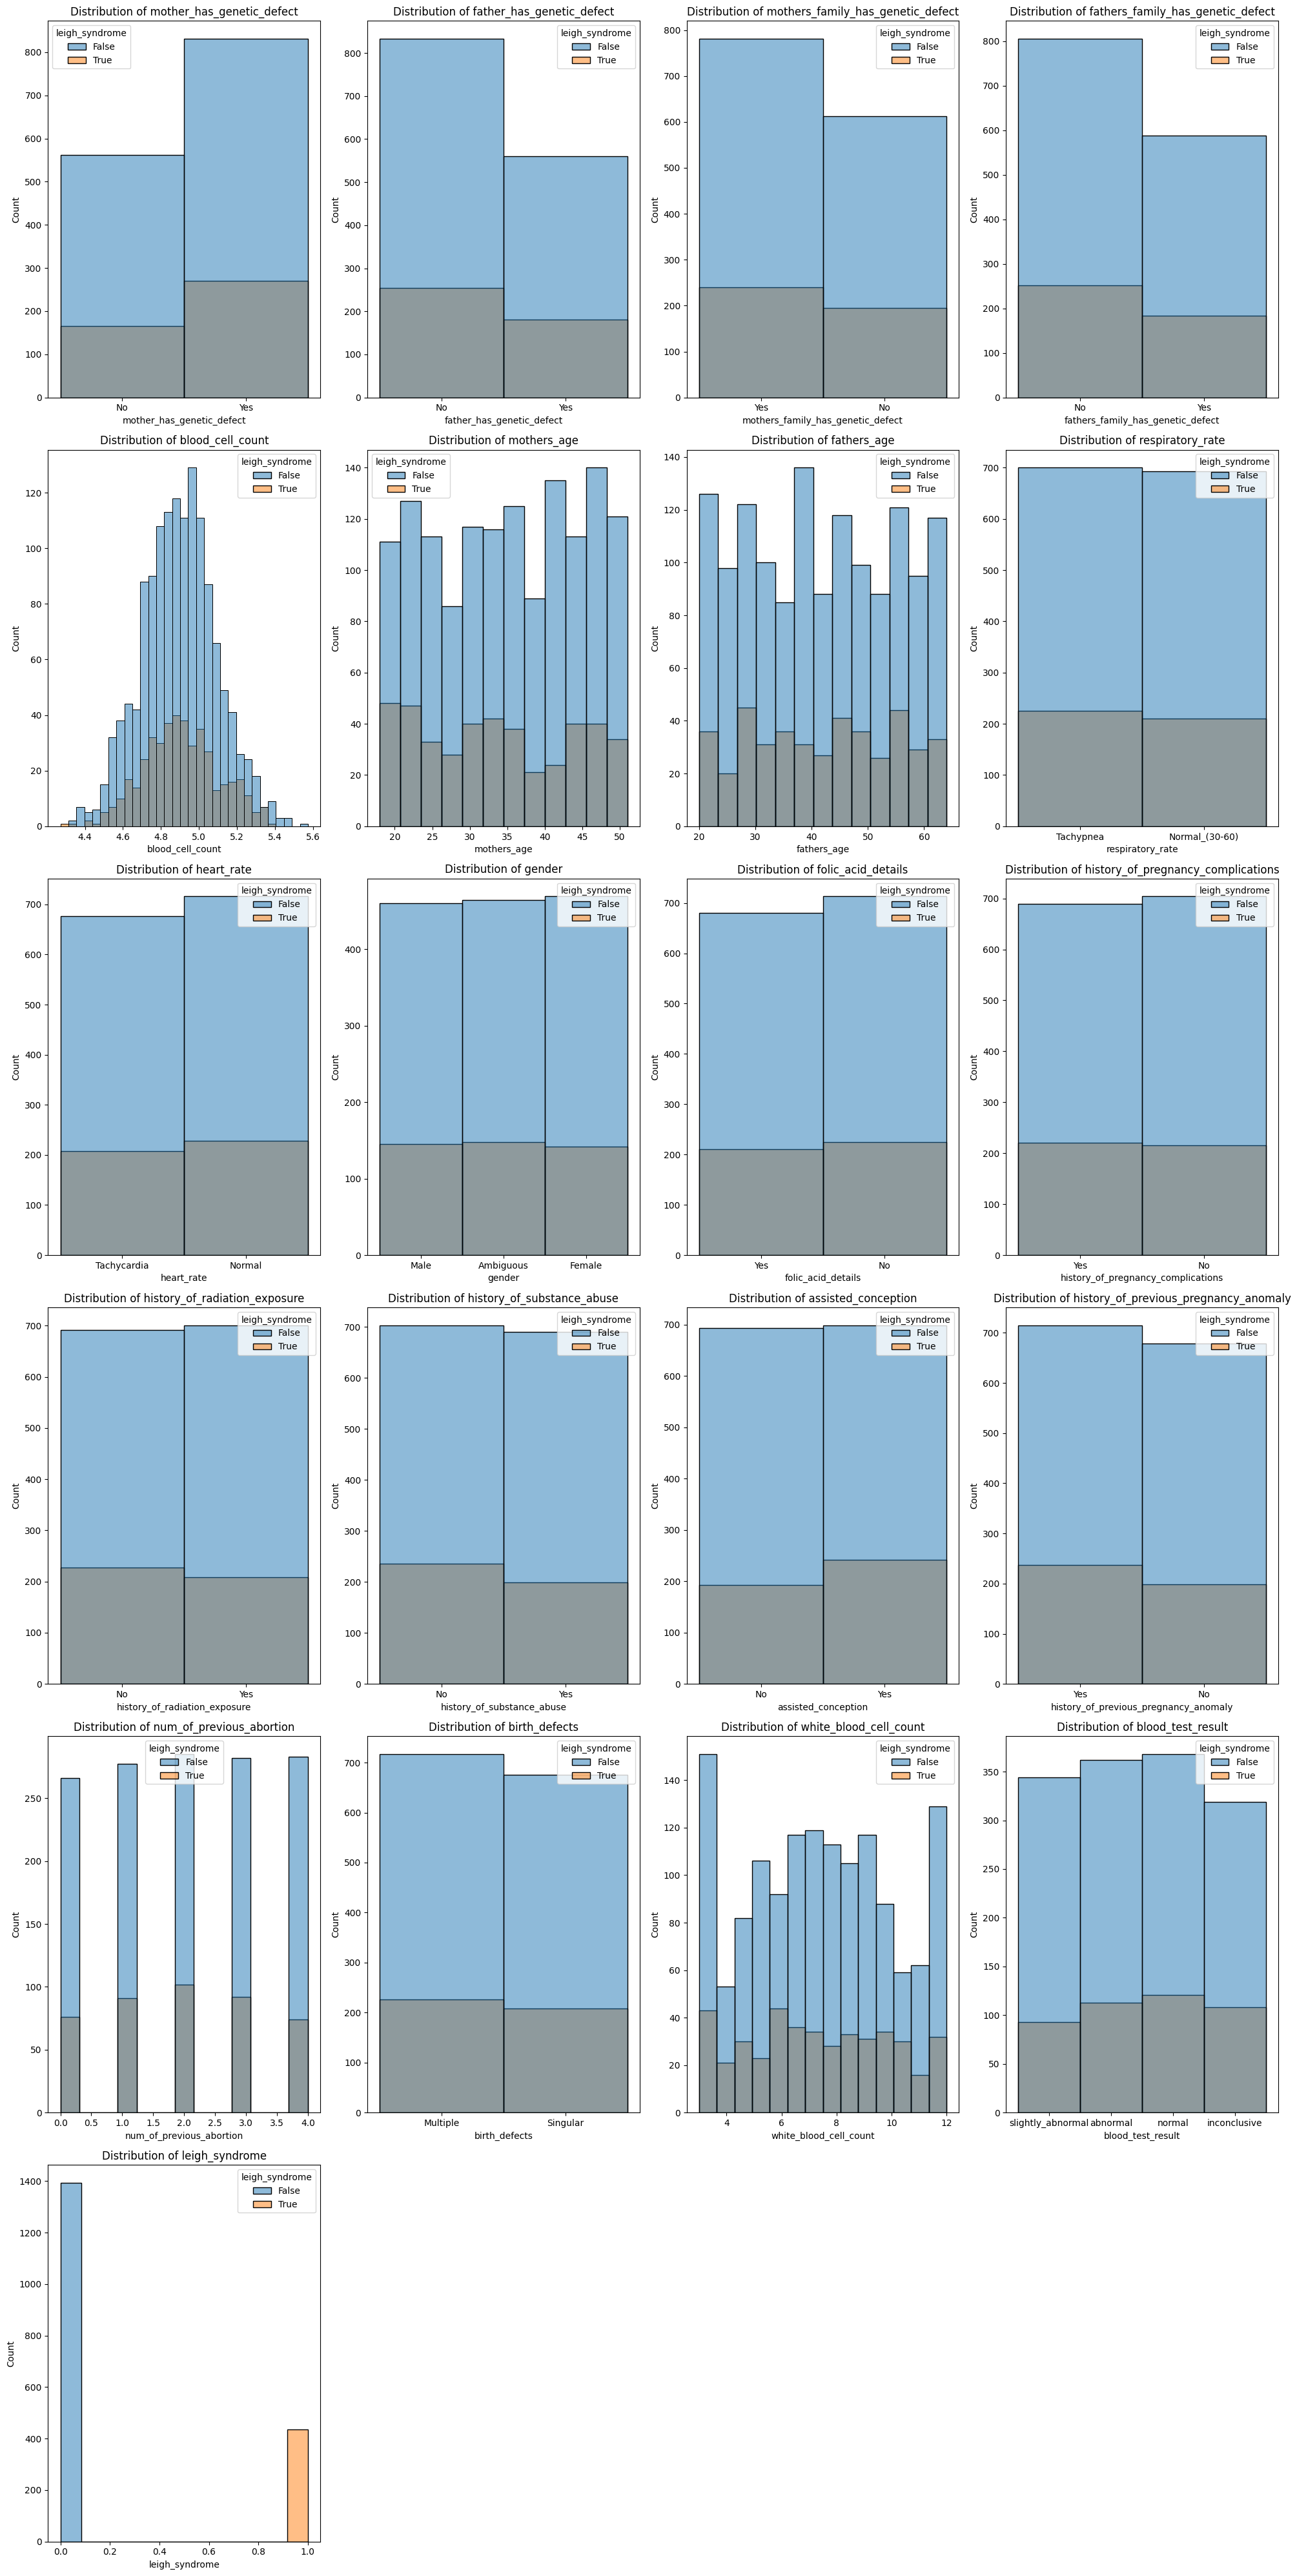

In [15]:
plt.figure(figsize = (20,40))
plotnumber = 1

for i in tqdm(range(21), desc="Loading..."):
    ax = plt.subplot(6, 4, plotnumber)
    sns.histplot(x = df.columns[i], hue='leigh_syndrome', data = df, ax = ax, legend=True, stat='count')
    plt.title(f'Distribution of {df.columns[i]}')
    plt.xticks()
    plotnumber += 1
        
plt.tight_layout()
plt.show()

Agora que fizemos um tratamento e análise inicial dos dados, vamos fazer um pré processamento deles para podermos separar em features (X) e target (y)

In [16]:
# Separando dados em X e y
X = df.drop('leigh_syndrome', axis=1).copy()
X.head()

,mother_has_genetic_defect,father_has_genetic_defect,mothers_family_has_genetic_defect,fathers_family_has_genetic_defect,blood_cell_count,mothers_age,fathers_age,respiratory_rate,heart_rate,gender,folic_acid_details,history_of_pregnancy_complications,history_of_radiation_exposure,history_of_substance_abuse,assisted_conception,history_of_previous_pregnancy_anomaly,num_of_previous_abortion,birth_defects,white_blood_cell_count,blood_test_result
0,No,No,Yes,No,5.209058,45.0,44.0,Tachypnea,Tachycardia,Male,Yes,Yes,No,No,No,Yes,0.0,Multiple,6.669552,slightly_abnormal
1,No,Yes,Yes,Yes,4.752272,44.0,42.0,Tachypnea,Tachycardia,Male,Yes,No,No,No,Yes,Yes,1.0,Multiple,6.397702,abnormal
2,Yes,Yes,Yes,No,4.751452,40.0,57.0,Normal_(30-60),Tachycardia,Ambiguous,No,No,Yes,No,Yes,Yes,3.0,Singular,9.382407,abnormal
3,No,Yes,Yes,Yes,4.876896,36.0,48.0,Tachypnea,Normal,Ambiguous,Yes,Yes,No,No,Yes,No,1.0,Singular,7.370477,normal
4,Yes,Yes,Yes,Yes,5.149614,23.0,49.0,Tachypnea,Normal,Female,Yes,No,Yes,Yes,No,Yes,0.0,Singular,9.855420,abnormal


In [17]:
# Separando dados em X e y
y = df['leigh_syndrome'].copy()
y.head()

0     True
1    False
2    False
3    False
4     True
Name: leigh_syndrome, dtype: bool

In [18]:
# Verificando os data types de X
X.dtypes

mother_has_genetic_defect                 object
father_has_genetic_defect                 object
mothers_family_has_genetic_defect         object
fathers_family_has_genetic_defect         object
blood_cell_count                         float64
mothers_age                              float64
fathers_age                              float64
respiratory_rate                          object
heart_rate                                object
gender                                    object
folic_acid_details                        object
history_of_pregnancy_complications        object
history_of_radiation_exposure             object
history_of_substance_abuse                object
assisted_conception                       object
history_of_previous_pregnancy_anomaly     object
num_of_previous_abortion                 float64
birth_defects                             object
white_blood_cell_count                   float64
blood_test_result                         object
dtype: object

In [19]:
# Remove FutureWarning
pd.set_option('future.no_silent_downcasting', True)

# Convertendo algumas colunas para Yes or No sem afetar os dados
X = X.rename(columns={'birth_defects': 'multiple_birth_defects'})
X['multiple_birth_defects'] = X['multiple_birth_defects'].apply(lambda x: 'Yes' if x == 'Multiple' else 'No')

# Usando o get_dummies para transformar as colunas categóricas em colunas binárias
X_encoded = pd.get_dummies(X, columns=['respiratory_rate', 'heart_rate', 'gender', 'blood_test_result'])

# Trocando todos os valores de Yes e No para 1 e 0
X_encoded = X_encoded.replace('Yes', 1)
X_encoded = X_encoded.replace(True, 1)
X_encoded = X_encoded.replace('No', 0)
X_encoded = X_encoded.replace(False, 0)

# Converter colunas para float64
X_encoded = X_encoded.astype('float64')

In [20]:
X_encoded.head()

,mother_has_genetic_defect,father_has_genetic_defect,mothers_family_has_genetic_defect,fathers_family_has_genetic_defect,blood_cell_count,mothers_age,fathers_age,folic_acid_details,history_of_pregnancy_complications,history_of_radiation_exposure,...,respiratory_rate_Tachypnea,heart_rate_Normal,heart_rate_Tachycardia,gender_Ambiguous,gender_Female,gender_Male,blood_test_result_abnormal,blood_test_result_inconclusive,blood_test_result_normal,blood_test_result_slightly_abnormal
0,0.0,0.0,1.0,0.0,5.209058,45.0,44.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,1.0,4.752272,44.0,42.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,4.751452,40.0,57.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,4.876896,36.0,48.0,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,1.0,1.0,5.149614,23.0,49.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [21]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   mother_has_genetic_defect              1828 non-null   float64
 1   father_has_genetic_defect              1828 non-null   float64
 2   mothers_family_has_genetic_defect      1828 non-null   float64
 3   fathers_family_has_genetic_defect      1828 non-null   float64
 4   blood_cell_count                       1828 non-null   float64
 5   mothers_age                            1828 non-null   float64
 6   fathers_age                            1828 non-null   float64
 7   folic_acid_details                     1828 non-null   float64
 8   history_of_pregnancy_complications     1828 non-null   float64
 9   history_of_radiation_exposure          1828 non-null   float64
 10  history_of_substance_abuse             1828 non-null   float64
 11  assi

In [22]:
# Trocar os valores de y para 1 e 0
y = y.replace(True, 1)
y = y.replace(False, 0)
y = y.astype('float64')

y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: leigh_syndrome, dtype: float64

In [23]:
# Ver a porcentagem de pacientes que tem leigh_syndrome
print(sum(y))
print(len(y))
print(sum(y) / len(y))

435.0
1828
0.23796498905908095


In [24]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1462, 27) (366, 27) (1462,) (366,)


In [25]:
# Ver a porcentagem de pacientes que tem leigh_syndrome após separar os dados
sum(y_train) / len(y_train)

0.22845417236662108

In [26]:
# Ver a porcentagem de pacientes que tem leigh_syndrome após separar os dados
sum(y_test) / len(y_test)

0.27595628415300544

In [27]:
# Criando o modelo XGBoost preliminar
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

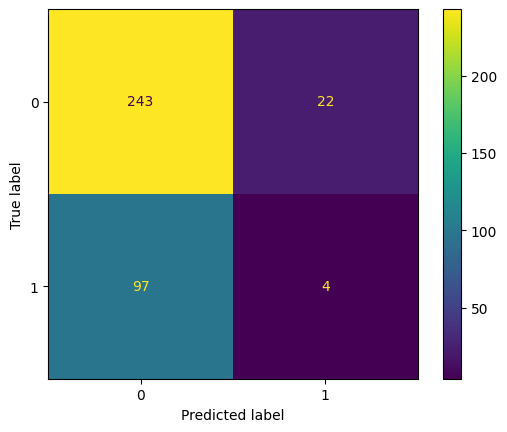

In [28]:
# Exibir a confusion matrix
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='horizontal')

In [29]:
# Configurando hiperparâmetros para o GridSearchCV do XGBoost para otimizar o modelo
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.1, 0.25, 0.5, 1],
    'reg_lambda': [0, 1, 10, 50]
}

scale_pos_weight= sum(y_train == 0) / sum(y_train == 1)

# GridSearchCV como temos muitos hiperparâmetros para otimizar, usamos GridSearchCV com valores potenciais para cada hiperparâmetro para encontrar os melhores valores
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(early_stopping_rounds=10, scale_pos_weight=scale_pos_weight),
    param_grid = param_grid,
    scoring = 'f1',
    cv = 3
)

optimal_params.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

gamma = optimal_params.best_params_['gamma']
learning_rate = optimal_params.best_params_['learning_rate']
max_depth = optimal_params.best_params_['max_depth']
reg_lambda = optimal_params.best_params_['reg_lambda']


print(optimal_params.best_params_)

{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 50}


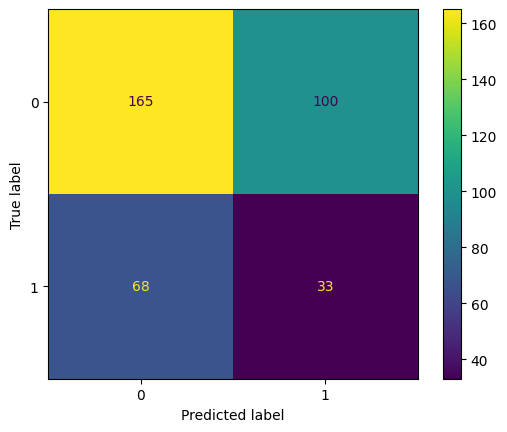

In [30]:
# Criando o modelo XGBoost com os hiperparâmetros otimizados
xgb_clf_opt = xgb.XGBClassifier(
    max_depth=max_depth,
    learning_rate=learning_rate,
    gamma=gamma,
    reg_lambda=reg_lambda,
    scale_pos_weight=scale_pos_weight # Para controlar o balanceamento de classes positivas no modelo dada a quantidade de classes negativas
)
xgb_clf_opt.fit(X_train, y_train)

# Exibir a confusion matrix
y_pred = xgb_clf_opt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='horizontal')

weight:  {'mother_has_genetic_defect': 11.0, 'father_has_genetic_defect': 10.0, 'mothers_family_has_genetic_defect': 20.0, 'fathers_family_has_genetic_defect': 19.0, 'blood_cell_count': 301.0, 'mothers_age': 161.0, 'fathers_age': 176.0, 'folic_acid_details': 19.0, 'history_of_pregnancy_complications': 11.0, 'history_of_radiation_exposure': 7.0, 'history_of_substance_abuse': 20.0, 'assisted_conception': 31.0, 'history_of_previous_pregnancy_anomaly': 37.0, 'num_of_previous_abortion': 111.0, 'multiple_birth_defects': 21.0, 'white_blood_cell_count': 231.0, 'respiratory_rate_Normal_(30-60)': 22.0, 'heart_rate_Normal': 14.0, 'gender_Ambiguous': 16.0, 'gender_Female': 46.0, 'gender_Male': 10.0, 'blood_test_result_abnormal': 39.0, 'blood_test_result_inconclusive': 15.0, 'blood_test_result_normal': 15.0, 'blood_test_result_slightly_abnormal': 13.0}
gain:  {'mother_has_genetic_defect': 2.1611616611480713, 'father_has_genetic_defect': 3.179567813873291, 'mothers_family_has_genetic_defect': 2.5313

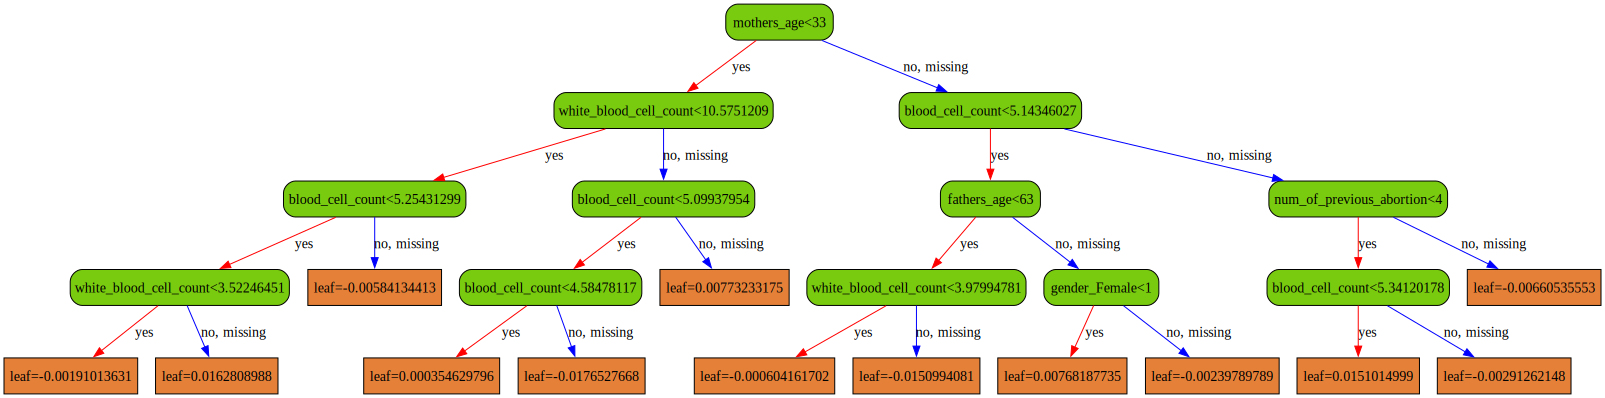

In [31]:
# Printar a XGBoost tree
bst = xgb_clf_opt.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', 'style': 'filled, rounded', 'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box', 'style': 'filled', 'fillcolor': '#e48038'}

xgb.to_graphviz(xgb_clf_opt, num_trees=0, size="10,10", condition_node_params=node_params, leaf_node_params=leaf_params)

In [32]:
# Avaliando outros modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

knnc = KNeighborsClassifier().fit(X_train,y_train)
cartc = DecisionTreeClassifier().fit(X_train,y_train)
rfc = RandomForestClassifier().fit(X_train,y_train)
gbmc = GradientBoostingClassifier().fit(X_train,y_train)
xgbc = xgb_clf_opt

In [38]:
# Resultados dos modelos
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
modelsc = [knnc, cartc, rfc, gbmc, xgbc]

# Create a DataFrame to store the results with appropriate data types
results = pd.DataFrame({
    'Model': pd.Series(dtype='str'),
    'ACC': pd.Series(dtype='float'),
    'F1-Score': pd.Series(dtype='float'),
    'Precision': pd.Series(dtype='float'),
    'Recall': pd.Series(dtype='float')
})

for model in modelsc:
    name = model.__class__.__name__
    predict = model.predict(X_test)
    acc = accuracy_score(y_test, predict)
    f1 = f1_score(y_test, predict)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)
    
    # Append the results to the DataFrame
    results = pd.concat([results, pd.DataFrame({'Model': [name], 'ACC': [acc], 'F1-Score': [f1], 'Precision': [precision], 'Recall': [recall]})], ignore_index=True)

# Print the results as a table
print(results)


                        Model       ACC  F1-Score  Precision    Recall
0        KNeighborsClassifier  0.674863  0.131387   0.250000  0.089109
1      DecisionTreeClassifier  0.620219  0.287179   0.297872  0.277228
2      RandomForestClassifier  0.721311  0.000000   0.000000  0.000000
3  GradientBoostingClassifier  0.710383  0.036364   0.222222  0.019802
4               XGBClassifier  0.540984  0.282051   0.248120  0.326733


ACC (Acurácia):
- Mede a proporção de previsões corretas em relação ao total de previsões.
- É útil para avaliar modelos de classificação.
- Quanto `mais próxima de 1` a acurácia, `melhor o modelo`.
- Exemplo: Se um modelo previu corretamente 90 de 100 casos, a acurácia é 0.9.

F1-Score:
- É a média harmônica entre a precisão e o recall.
- É útil quando há uma distribuição desigual entre as classes.
- Quanto `mais próximo de 1` o F1-Score, `melhor o modelo`.
- Exemplo: Um F1-Score de 0.8 indica um bom equilíbrio entre precisão e recall.

Precision (Precisão):
- Mede a proporção de verdadeiros positivos entre os positivos preditos.
- É útil quando o custo de falsos positivos é alto.
- Quanto `mais próxima de 1` a precisão, `melhor o modelo`.
- Exemplo: Uma precisão de 0.9 significa que 90% das previsões positivas estão corretas.

Recall (Revocação):
- Mede a proporção de verdadeiros positivos entre os positivos reais.
- É útil quando o custo de falsos negativos é alto.
- Quanto `mais próximo de 1` o recall, `melhor o modelo`.
- Exemplo: Um recall de 0.8 significa que 80% dos casos positivos reais foram identificados corretamente pelo modelo.